## Dataset Introduction

In [202]:

# Importing required libraries for analysis
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import learning_curve


In [203]:
# Read data into csv, check data
df = pd.read_csv("./ufc-master.csv")
df.head()

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Date,Location,Country,Winner,...,FinishDetails,FinishRound,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds
0,Alexandre Pantoja,Kai Asakura,-250.0,215.0,40.0000,215.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,Rear Naked Choke,2.0,2:05,425.0,300.0,800.0,150.0,2500.0,400.0,350.0
1,Shavkat Rakhmonov,Ian Machado Garry,-210.0,295.0,47.6190,295.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,NaN,5.0,5:00,1500.0,250.0,650.0,180.0,3000.0,240.0,700.0
2,Ciryl Gane,Alexander Volkov,-380.0,300.0,26.3158,300.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,NaN,3.0,5:00,900.0,-160.0,450.0,1100.0,3000.0,350.0,1100.0
3,Bryce Mitchell,Kron Gracie,-950.0,625.0,10.5263,625.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,Elbows,3.0,0:39,639.0,-200.0,1100.0,380.0,1400.0,500.0,4000.0
4,Nate Landwehr,Dooho Choi,-130.0,110.0,76.9231,110.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Blue,...,Elbows,3.0,3:21,801.0,275.0,550.0,500.0,700.0,300.0,250.0


In [204]:
# Check the number of rows and columns in the dataset
print(f"This dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

This dataset has 6528 rows and 118 columns.


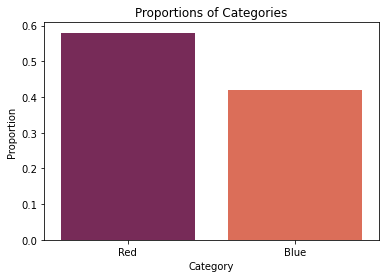

In [205]:
# Check red vs. blue win counts
proportions = df['Winner'].value_counts(normalize=True)

# Create a bar plot of the proportions
sns.barplot(x=proportions.index, y=proportions.values, palette='rocket')

# Customize the plot (optional)
plt.title('Proportions of Categories')
plt.xlabel('Category')
plt.ylabel('Proportion')
plt.show()

## Data Exploration & Preprocessing

First of all, looking at our data, we can see that our target variable "Winner" provides values of either "Red" or "Blue". We  will encode these as numeric vaslues - 0 for blue and 1 for red for the purpose of looking into correlation. There are many other adjustments to make for the data, but for now we will start with a simple correlation analysis.

In [206]:
# Efficiently converting the winner column to a boolean, which is casted to int
df['Winner'] = (df['Winner'] == 'Blue').astype(int)

In [207]:
# Adjust pandas display settings to show all rows without truncation
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.width', None)     # Prevent line wrapping
pd.set_option('display.max_colwidth', None)  # Show full content of each cell

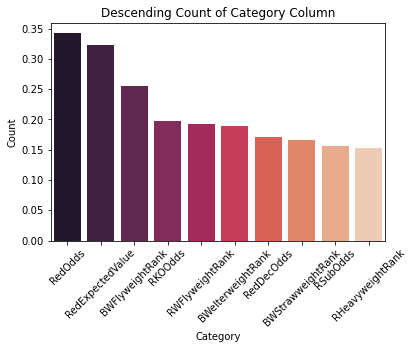

In [208]:
# Including only the numeric columns to check our correlation
numeric_df = df.select_dtypes(include=['number'])
winner_correlation = numeric_df.corr()['Winner'].sort_values(ascending=False)

# Plot the correlation in descending order
sns.barplot(x=winner_correlation.drop('Winner').head(10).index, y=winner_correlation.drop('Winner').head(10).values, palette='rocket')
plt.title('Descending Count of Category Column')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### NaN Handling

There are frequent NaN values that need to be handled in order to implement most machine learning algorithms. We will continue to address these and more in this section. To start, we will remove rows with null values > 50%.

In [209]:
# Calculate the proportion of null values for each column
null_proportions = df.isna().mean()

# Filter out columns with null proportions > 50%
filtered_data = df.loc[:, null_proportions <= 0.5]

# Double checking removed columns
removed_data = df.loc[:, null_proportions > 0.5]
removed_data.columns

Index(['BMatchWCRank', 'RMatchWCRank', 'RWFlyweightRank',
       'RWFeatherweightRank', 'RWStrawweightRank', 'RWBantamweightRank',
       'RHeavyweightRank', 'RLightHeavyweightRank', 'RMiddleweightRank',
       'RWelterweightRank', 'RLightweightRank', 'RFeatherweightRank',
       'RBantamweightRank', 'RFlyweightRank', 'RPFPRank', 'BWFlyweightRank',
       'BWFeatherweightRank', 'BWStrawweightRank', 'BWBantamweightRank',
       'BHeavyweightRank', 'BLightHeavyweightRank', 'BMiddleweightRank',
       'BWelterweightRank', 'BLightweightRank', 'BFeatherweightRank',
       'BBantamweightRank', 'BFlyweightRank', 'BPFPRank', 'FinishDetails'],
      dtype='object')

Looking at the above, it seems that the majority of values getting caught by our filter are the ranking values. In MMA, many competitors are unranked as the UFC only tracks the top 15 for each division. Let us double check our hypothesis by reviewing the max value for these columns.

In [210]:
# Checking the values for our filtered out columns
removed_data.max()

BMatchWCRank             15.0
RMatchWCRank             15.0
RWFlyweightRank          15.0
RWFeatherweightRank       0.0
RWStrawweightRank        15.0
RWBantamweightRank       15.0
RHeavyweightRank         15.0
RLightHeavyweightRank    15.0
RMiddleweightRank        15.0
RWelterweightRank        15.0
RLightweightRank         15.0
RFeatherweightRank       15.0
RBantamweightRank        15.0
RFlyweightRank           15.0
RPFPRank                 15.0
BWFlyweightRank          15.0
BWFeatherweightRank       0.0
BWStrawweightRank        15.0
BWBantamweightRank       15.0
BHeavyweightRank         15.0
BLightHeavyweightRank    15.0
BMiddleweightRank        15.0
BWelterweightRank        15.0
BLightweightRank         15.0
BFeatherweightRank       15.0
BBantamweightRank        15.0
BFlyweightRank           15.0
BPFPRank                 15.0
dtype: float64

In [211]:
# Spot check data to validate ranking behaviors
check = df[df[removed_data.columns].isna().any(axis=1)].head(3)
cols_of_interest = ['RedFighter', 'BlueFighter'] + list(removed_data.columns)
check[cols_of_interest]

,RedFighter,BlueFighter,BMatchWCRank,RMatchWCRank,RWFlyweightRank,RWFeatherweightRank,RWStrawweightRank,RWBantamweightRank,RHeavyweightRank,RLightHeavyweightRank,...,BHeavyweightRank,BLightHeavyweightRank,BMiddleweightRank,BWelterweightRank,BLightweightRank,BFeatherweightRank,BBantamweightRank,BFlyweightRank,BPFPRank,FinishDetails
0,Alexandre Pantoja,Kai Asakura,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rear Naked Choke
1,Shavkat Rakhmonov,Ian Machado Garry,7.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN
2,Ciryl Gane,Alexander Volkov,3.0,2.0,NaN,NaN,NaN,NaN,2.0,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Looks like our hypothesis is correct. Furthermore, based on our spot check, we can also see that fighters that do not fight in other weight classes are not ranked in those weight classes (which makes sense).

Rather than allowing these NaN values to be filtered, let us instead reformat them to be ranked as 99 - a high number that identifies unranked fighters but allows us to handle these as numeric values.

In [212]:
df.filter(like='Rank').columns

Index(['BMatchWCRank', 'RMatchWCRank', 'RWFlyweightRank',
       'RWFeatherweightRank', 'RWStrawweightRank', 'RWBantamweightRank',
       'RHeavyweightRank', 'RLightHeavyweightRank', 'RMiddleweightRank',
       'RWelterweightRank', 'RLightweightRank', 'RFeatherweightRank',
       'RBantamweightRank', 'RFlyweightRank', 'RPFPRank', 'BWFlyweightRank',
       'BWFeatherweightRank', 'BWStrawweightRank', 'BWBantamweightRank',
       'BHeavyweightRank', 'BLightHeavyweightRank', 'BMiddleweightRank',
       'BWelterweightRank', 'BLightweightRank', 'BFeatherweightRank',
       'BBantamweightRank', 'BFlyweightRank', 'BPFPRank', 'BetterRank'],
      dtype='object')

In [213]:
# Fill nulls for all columns that are rank based, excluding BetterRank, which identifies Blue or Red
rank_columns = [col for col in df.filter(like='Rank').columns if col != 'BetterRank']
df[rank_columns] = df[rank_columns].fillna(99)

# Once complete, check null percentages again
df.isna().mean().sort_values(ascending=False).head(10)

FinishDetails          0.556985
EmptyArena             0.227635
BKOOdds                0.208333
BSubOdds               0.208180
RSubOdds               0.204657
RKOOdds                0.204350
BlueDecOdds            0.170956
RedDecOdds             0.166513
BlueAvgSigStrLanded    0.142463
BlueAvgTDPct           0.128983
dtype: float64

Our encoding is a major success, the remaining data in our dataframe only contains one more column with a high proportion of null values. Luckily, this also makes sense. The remaining column with a 56% null rate is our 'FinishDetails' column. Using the exploration of our metadata thus far, we can safely assume that fights that do not end in a finish, or are missing details are marked as NaN for that fight.

Based on this fact, let us simply mark NaN values for FinishDetails as "Unknown".

In [214]:
# Fill nulls for finish details column to be unknown
df['FinishDetails'] = df['FinishDetails'].fillna('Unknown')

# Perform a final check on our null proportions
df.isna().mean().sort_values(ascending=False).head(10)

EmptyArena             0.227635
BKOOdds                0.208333
BSubOdds               0.208180
RSubOdds               0.204657
RKOOdds                0.204350
BlueDecOdds            0.170956
RedDecOdds             0.166513
BlueAvgSigStrLanded    0.142463
BlueAvgTDPct           0.128983
BlueAvgTDLanded        0.127604
dtype: float64

### Odds Reformatting

> **NOTE:** The following section is solely for demonstration purposes of how to leverage included odds values to improve upon these indicators to build the best model possible. In our challenge implementation, we will be trying to outperform oddsmakers using other predictors. Technically speaking however, we can achieve a more accurate model by following the included reformatting of odds values as another predictor.

In addition to the completed changes, we could benefit from reformatting our odds values to be probabilities (from 0 to 1) for clarity and baseline accuracy as a predictor.

Moneyline odds (the provided format in the dataset) represent how much profit you will make on your bet. For example, if the odd is +150 and you bet $100 the total you could win is $250. Alternatively, a negative odd demonstrates how much you need to wager to win $100.

This can easily be converted to probability values by applying the following calculations to our odds values:

- For negative odds: Implied Probability = Odds / (Odds + 100) * 100 
- For positive odds: Implied Probability = 100 / (Odds + 100) * 100

In [215]:
# Exploring odds values of the dataset
odds_columns = df.filter(like='Odds')
print(odds_columns)

      RedOdds  BlueOdds  RedDecOdds  BlueDecOdds  RSubOdds  BSubOdds  RKOOdds  \
0      -250.0     215.0       300.0        800.0     150.0    2500.0    400.0   
1      -210.0     295.0       250.0        650.0     180.0    3000.0    240.0   
2      -380.0     300.0      -160.0        450.0    1100.0    3000.0    350.0   
3      -950.0     625.0      -200.0       1100.0     380.0    1400.0    500.0   
4      -130.0     110.0       275.0        550.0     500.0     700.0    300.0   
5      -380.0     300.0       250.0        750.0    1200.0    1200.0   -125.0   
6      -650.0    -162.0       450.0        130.0     450.0     900.0    600.0   
7      -238.0     195.0      -135.0        275.0    1600.0    1100.0    550.0   
8       150.0    -180.0       400.0        185.0    1000.0     550.0    450.0   
9      -112.0    -108.0       150.0        200.0    1000.0    1800.0    650.0   
10      142.0    -170.0       300.0        250.0     550.0     800.0    900.0   
11     -130.0     110.0     

Based on the above, we can see that there are 7 odds value columns that need to be converted. We can convert moneyline odds to **implied probability** using these formulas:

$$
\text{Implied Probability} =
\begin{cases} 
\frac{100}{\text{Odds} + 100}, & \text{if Odds > 0 (Underdog)} \\
\frac{-\text{Odds}}{-\text{Odds} + 100}, & \text{if Odds < 0 (Favorite)}
\end{cases}
$$

In [216]:
def moneyline_to_prob(odds):
    """Convert American moneyline odds to implied probability."""
    if odds > 0:  
        # Odds > 0 implies this fighter is the underdog
        return 100 / (odds + 100)
    elif odds < 0:  
        # Odds < 0 implies this fighter is the favorite
        return -odds / (-odds + 100)
    else:
        # In the case of NaN and other edge cases, count this as an even odds fight
        return 0.5  

# Select all columns that contain "Odds"
odds_columns = df.filter(like="Odds").columns

# Apply conversion
df[odds_columns] = df[odds_columns].applymap(moneyline_to_prob)

# Exploring odds values again
odds_columns = df.filter(like='Odds')
print(odds_columns)

       RedOdds  BlueOdds  RedDecOdds  BlueDecOdds  RSubOdds  BSubOdds  \
0     0.714286  0.317460    0.250000     0.111111  0.400000  0.038462   
1     0.677419  0.253165    0.285714     0.133333  0.357143  0.032258   
2     0.791667  0.250000    0.615385     0.181818  0.083333  0.032258   
3     0.904762  0.137931    0.666667     0.083333  0.208333  0.066667   
4     0.565217  0.476190    0.266667     0.153846  0.166667  0.125000   
5     0.791667  0.250000    0.285714     0.117647  0.076923  0.076923   
6     0.866667  0.618321    0.181818     0.434783  0.181818  0.100000   
7     0.704142  0.338983    0.574468     0.266667  0.058824  0.083333   
8     0.400000  0.642857    0.200000     0.350877  0.090909  0.153846   
9     0.528302  0.519231    0.400000     0.333333  0.090909  0.052632   
10    0.413223  0.629630    0.250000     0.285714  0.153846  0.111111   
11    0.565217  0.476190    0.333333     0.333333  0.222222  0.052632   
12    0.125000  0.916667    0.076923     0.307692  

With that, our odds values handling is reading for intuitive usage and evaluation. There is one big consideration left, which is to encode our categorical variables for later usage in our model. 

### Converting Time Values

This one is pretty straightforward but important for cleanliness. We will ensure that the current format of timed matches (m:ss) is converted to seconds.

In [217]:
# Function to convert m:ss to seconds
def convert_to_seconds(time_str):
    # Check for valid strings in m:ss format
    if isinstance(time_str, str) and ':' in time_str:
        try:
            # Applying our minute and second conversion using split
            minutes, seconds = map(int, time_str.split(':')) 
            # Return total seconds the fight took
            return minutes * 60 + seconds  
        except ValueError:
            # Return NaN for any invalid time formats
            return float('nan')
    # Return NaN if the entry is not a string
    return float('nan')  

# Apply the conversion function to the 'FinishRoundTime' column
df['FinishRoundTime'] = df['FinishRoundTime'].apply(convert_to_seconds)

# Ensure to cleanup after the NaNs that we created by filling them with the mean time
print(f"Mean match time: {df['FinishRoundTime'].mean()}")
df['FinishRoundTime'] = df['FinishRoundTime'].fillna(df['FinishRoundTime'].mean())

Mean match time: 230.3333897731121


### Encoding Categorical Variables

As covered in the Udactiy Data Science Nanodegree program, there are two main options:

1. One-Hot Encoding
    - This approach works well for nominal data, i.e. data that has no inherent order
    - This includes something like fighter stance (orthodox or southpaw), fight finish details, and more
2. Label Encoding
    - This approach works best for ordinal data, i.e. data that has a meaningful order that needs to be preserved
    - Fighter ranking is a good example of ordinal data within this UFC dataset

After further review of the metadata, I have decided upon the following selection to perform based on my experience and understanding of MMA fights:

1. One-Hot Encoded Features
    - Location
    - Country
    - TitleBout
    - WeightClass
    - Gender
    - BlueStance / RedStance
    - BetterRank
    - Finish
    - FinishDetails

2. Label Encoded Features
    - Rank
    - FinishRound

In [218]:
# Encoding our features

# List of columns to one-hot encode
one_hot_cols = ['Location', 'Country', 'TitleBout', 'WeightClass', 'Gender', 
                'BlueStance', 'RedStance', 'BetterRank', 'Finish', 'FinishDetails']

# List of columns to label encode (ordinal categories) 
label_encode_cols = ['FinishRound']

# Apply one-hot encoding
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

# Apply label encoding for ordinal categories
label_encoders = {}

for col in label_encode_cols:
    le = LabelEncoder()
    # Transform columns using label encoder
    df[col] = le.fit_transform(df[col])
    # Store encoder for inverse transformation if needed
    label_encoders[col] = le

print("Encoding Complete!")

Encoding Complete!


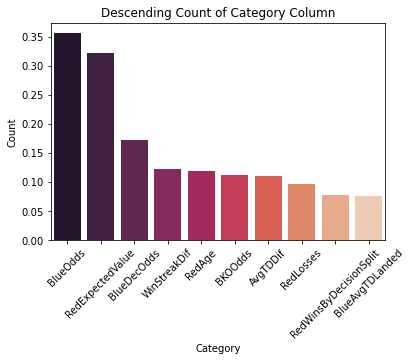

In [219]:
# Reapplying our numeric features
numeric_df = df.select_dtypes(include=['number'])
adjusted_winner_correlation = numeric_df.corr()['Winner'].sort_values(ascending=False)

# Plot the correlation in descending order
sns.barplot(x=adjusted_winner_correlation.drop('Winner').head(10).index, y=adjusted_winner_correlation.drop('Winner').head(10).values, palette='rocket')
plt.title('Descending Count of Category Column')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Baseline Odds Accuracy

Before model implementation, lets fetch a baseline accuracy reading of the provided odds. We will do this by using the provided odds to create a new column: 'Favorite' and compare its values against the real fight winner.

In [220]:
# Remove remaining nulls that will interrupt our classificaiton
df = df.dropna()

# Function to classify red or blue favorite 
def classify_favorite(red_odds):
    return 0 if float(red_odds) < 0 else 1

# Apply function to create a new column
df['Favorite'] = df['RedOdds'].apply(classify_favorite)
accuracy = accuracy_score(df['Favorite'], df['Winner'])

# Format the accuracy to 2 decimal places
formatted_accuracy = round(accuracy, 2)

# Prepare the readable output
print(f"Oddsmakers were right {formatted_accuracy * 100}% of the time.")

Oddsmakers were right 42.0% of the time.


Not super great results for our odds makers. This is perfectly normal though, as the MMA game is unpredictable! This means that the number we are trying to beat is 42% for the accuracy of our model.

## Model Implementation

In [221]:
# Some final cleanup 
df = df.drop(columns = ['RedFighter', 'BlueFighter', 'Date'])

# Bonus challenge! Run below command to view model results WITHOUT provided odds!
df = df.drop(columns = list(odds_columns) + ['RedExpectedValue', 'BlueExpectedValue'])

### Split Train and Test Data

In [222]:
# Define features and target
X = df.drop(columns=["Winner"])  # Features
y = df["Winner"]  # Target variable

# Split into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (2761, 347)
Test set: (691, 347)


### Learning Curve

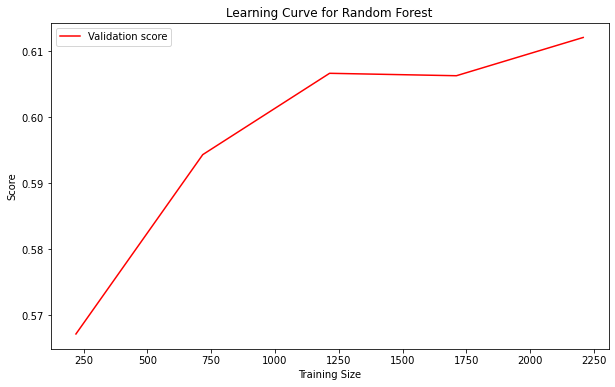

In [223]:
# Intantiate our model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Calculate learning curve
train_sizes, train_scores, test_scores = learning_curve(rf, X_train, y_train, cv=5)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation score', color='red')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve for Random Forest')
plt.legend()
plt.show()

### Model Training

In [224]:
# Fitting our instantiated model using our train data
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Hyperparameter Tuning

In [225]:
# Define parameter grid for hyperparameter tuning
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Run grid search
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

## Model Evaluation

### Best Parameters and Score

In [226]:
# Calculating our best parameters throught he grid search along with the best score
print("Best parameters:", grid_search.best_params_)
print("Best Score (Cross-Validation)", grid_search.best_score_)

Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best Score (Cross-Validation) 0.620067091228346


### Making Predictions

In [227]:
# Predict on test data
y_pred = grid_search.best_estimator_.predict(X_test)

# Model Performance
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Test Accuracy: {accuracy:.4f}")

# Detailed Classification Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

✅ Test Accuracy: 0.6295
              precision    recall  f1-score   support

           0       0.63      0.87      0.73       399
           1       0.63      0.30      0.41       292

    accuracy                           0.63       691
   macro avg       0.63      0.59      0.57       691
weighted avg       0.63      0.63      0.59       691

Confusion Matrix:
[[346  53]
 [203  89]]


### Finding Important Features

In [228]:
# Get feature importances from the best model
importances = grid_search.best_estimator_.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Display top 10 important features
print(feature_importance_df.head(5))

                Feature  Importance
58               AgeDif    0.030973
59            SigStrDif    0.029950
5      BlueAvgSigStrPct    0.028081
4   BlueAvgSigStrLanded    0.027682
61             AvgTDDif    0.027637


# Results

Drumroll please ... 

### 🥇 Best Model Results
- Best Parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
- Cross-Validation Score: 62% Accuracy Score
- Test Set Performance: 63% Accuracy on Test Set

## 🔍 Key Insights
- The top features in this model are the following (in order):
  1. The difference in age between the fighters
  2. The difference in significant strikes landed between fighters
  3. The average significant strikes for each fighter
  4. The average difference in takedowns between fighters

## 🐾 Next Steps
- This is the first iteration of this project and I can immediately think of many ways that the model I have built can be used and improved. What immediately comes to mind is the companion CSV file that was provided with this dataset - upcoming.csv. This file contains a list of set up fights including December 2024, a month that has already past. This means we can use the model against real data and evaluate the results against the fights that ended up occuring (if they were not canceled) which would be a real test of the usability of this model and others like it.

- In terms of improvements, there are many that have come to my mind as well, such as "Home Court Advantage" - exploring the correlation of when a fighter is fighting in their city / country versues travelling abroad to compete.

- Another correlation I believe is worth comparing is the correlation between being in the red corner / wearing red jersies or fight equipment and winning. This is a concept I had first heard about in Brazilian Jiu Jitsu, and I was impressed to find that about 60% of all victors in this dataset were from the red corner, which is definitely a significant gap and a potential contributor.